In [211]:
import datetime
import pandas as pd
import requests
import re

In [262]:
from bs4 import BeautifulSoup

In [261]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scrape announcements

## Parse announcements from aggregator webpage: https://appt.ch/

In [156]:
URL = 'https://appt.ch/annonces/page-100'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

In [322]:
def str_extract(bf_elem):
    """
    Process text string obtained from BeatifulSoup .text object:
        - Detect when no .text object is found
        - Replace repeated spaces and tabs by a single space
        - Replace inner HTML tags
    """
    if bf_elem == None:
        return ''
    else:
        bf_text = bf_elem.get_text(separator='\n',strip=True) # Replace HTML tagss with \n
        bf_text = bf_text.replace('m\n2','m2')                          # Compensate for tag indicating m2
        
    return re.sub(r'\b(\s+\t+)\b', ' ', bf_text)

In [364]:
def process_info(info_str):
    """
    Process info string containing different fields separated by '\n', and return it in dict of integers
        - Fields:
            * 'Pièces' -> 'rooms'
            * 'Étage' -> 'floor'
            * 'Surface' -> 'surface'
    """
        
    info_list = info_str.split('\n')
    
    info_dict= {'rooms': None,
                'floor': None,
                'surface': None}
    
    for field in info_list:
        if field.split(':')[0] == 'Pièces':
            try:
                info_dict['rooms'] = float(re.findall(r'(\d+)', field.split(':')[1])[0])
            except:
                pass
        elif field.split(':')[0] == 'Étage':
            try:
                info_dict['floor'] = int(re.findall(r'(\d+)', field.split(':')[1])[0])
            except:
                pass
        elif field.split(':')[0] == 'Surface':
            try:
                info_dict['surface'] = int(re.findall(r'(\d+)', field.split(':')[1])[0])        
            except:
                pass
        
    return info_dict

info_str = 'Pièces: 6\nÉtage: 6ème\nSurface: 175m2'

process_info(info_str)

{'rooms': 6.0, 'floor': 6, 'surface': 175}

In [365]:
def process_date(date_str):
    """
    Return datetime object from date string indicating N days in the past counting from today in french. 
        - Today: "Aujourd'hui" -> current_date
        - Yesterday: "Hier" -> current_date - 1 day
        - X days ago: "Il y a X jours" -> current_date - 10 days
    """
    
    date_str = date_str.lower()
    
    comp_re = re.compile(r'il y a (\d+) jour')
    
    if date_str == 'aujourd\'hui':
        date = datetime.datetime().now()
    
    elif date_str == 'hier':
        date = datetime.datetime.now() - datetime.timedelta(days=1)
    
    elif comp_re.match(date_str):
        delta_days = int(comp_re.findall(date_str)[0])
        date = datetime.datetime.now()-datetime.timedelta(days=delta_days)
    else:
        date = None
    
    date = date.replace(hour=0, minute=0, second=0, microsecond=0)
    return date

def process_price(price_str):
    """
    Return integer indicating price obtained from string of the form: '1330.00.-'
    """
    try:
        price = int(price_str.split('.')[0])
    except ValueError:
        price = None
        
    return price 


In [381]:
results = soup.find(id='main')
ad_elems = results.find_all('article', class_='ad excerpt')


ad_dict = {'id_appturl': [],
           'title': [],
           'street': [],
           'postal': [],
           'price': [],
           'info': [],
           'rooms': [],
           'floor': [],
           'surface': [],
           'link': [],
           'date': []}

for ad_elem in ad_elems:
    title = str_extract(ad_elem.find('h1', class_='title'))
    price_elem = ad_elem.find('p', class_='price')
    price = process_price(str_extract(price_elem.find('span')))
    postal = str_extract(ad_elem.find('span', class_='postal-code'))
    street = str_extract(ad_elem.find('span', class_='street'))
    date = process_date(str_extract(ad_elem.find('span', class_='date')))
    link = ad_elem.find('a')['href']
    ad_id = link.split('/')[-1]
    
    info = str_extract(ad_elem.find('p', class_='more-infos'))
    info_dict = process_info(info)
    rooms = info_dict['rooms']
    floor = info_dict['floor']
    surface = info_dict['surface']
    
#    print(f'TITLE:  {title}')
#    print(f'STREET: {street}')
#    print(f'POSTAL: {postal}')
#    print(f'PRICE:  {price}')
#    print(f'INFO:   {info}')
#    print(f'LINK:   {link}')
#    print(f'DATE:   {date}')
    
    ad_dict['id_appturl'].append(ad_id)
    ad_dict['title'].append(title)
    ad_dict['street'].append(street)
    ad_dict['postal'].append(postal)
    ad_dict['price'].append(price)
    ad_dict['info'].append(info)
    ad_dict['rooms'].append(rooms)
    ad_dict['floor'].append(floor)
    ad_dict['surface'].append(surface)
    ad_dict['link'].append(link)
    ad_dict['date'].append(date)
    

In [367]:
ad_df = pd.DataFrame(ad_dict)
ad_df.set_index('id_appturl')
ad_df.drop_duplicates('id_appturl', inplace=True)
ad_df

,id_appturl,title,street,postal,price,info,rooms,floor,surface,link,date
0,1497568057,Studio proche de toutes les commodités,Rue Jean-Antoine-Gautier 16,1201 Genève,1330.0,Pièces: 1\nÉtage: 5\nSurface: 34m2,1.0,5.0,34.0,https://appt.ch/annonces/1497568057,2021-04-07
1,410302133,Appartement de 2 pièces au 2ème étage.,Rue de Savoie 11,1207 Genève,1340.0,Pièces: 2\nÉtage: 2\nSurface: 24m2,2.0,2.0,24.0,https://appt.ch/annonces/410302133,2021-04-07
2,1895383257,Appartement de 7 pièces au 5ème étage,Chemin Rieu 2,1208 Genève,3685.0,Pièces: 7,7.0,NaN,NaN,https://appt.ch/annonces/1895383257,2021-04-07
3,2145754844,Appartement attique 3 pièces au6ème étage avec...,Rue du Village-Suisse 8,1204 Genève,1910.0,Pièces: 3\nSurface: 40m2,3.0,NaN,40.0,https://appt.ch/annonces/2145754844,2021-04-07
4,3594153976,Appartement traversant de 5 pièces au 3ème éta...,Route du Grand-Lancy 87 BIS,1212 Grand-Lancy,2180.0,Pièces: 5,5.0,NaN,NaN,https://appt.ch/annonces/3594153976,2021-04-07
...,...,...,...,...,...,...,...,...,...,...,...
644,3305772437,Studio,Rue Du Mont-blanc 17,1200 Genève,2150.0,,NaN,NaN,NaN,https://appt.ch/annonces/3305772437,2020-07-02
645,2413422117,Appartement Atypique - Genève,Rue du Môle 32,1201 Genève,3500.0,Pièces: 6\nSurface: 120m2,6.0,NaN,120.0,https://appt.ch/annonces/2413422117,2020-06-07
646,3419977751,Magnifique appartement de 4.5 pièces duplex au...,Rue de la Gare 6,1434 Ependes VD,1800.0,Pièces: 4.5\nÉtage: 1er,4.0,1.0,NaN,https://appt.ch/annonces/3419977751,2020-02-18
647,2240539588,Appartement Standing - Plein centre ville,Genève,,6200.0,Pièces: 6\nÉtage: 6ème\nSurface: 175m2,6.0,6.0,175.0,https://appt.ch/annonces/2240539588,2019-10-23


In [380]:
ad_df.loc[ad_df['price']<2000]

,id_appturl,title,street,postal,price,info,rooms,floor,surface,link,date
0,1497568057,Studio proche de toutes les commodités,Rue Jean-Antoine-Gautier 16,1201 Genève,1330.0,Pièces: 1\nÉtage: 5\nSurface: 34m2,1.0,5.0,34.0,https://appt.ch/annonces/1497568057,2021-04-07
1,410302133,Appartement de 2 pièces au 2ème étage.,Rue de Savoie 11,1207 Genève,1340.0,Pièces: 2\nÉtage: 2\nSurface: 24m2,2.0,2.0,24.0,https://appt.ch/annonces/410302133,2021-04-07
3,2145754844,Appartement attique 3 pièces au6ème étage avec...,Rue du Village-Suisse 8,1204 Genève,1910.0,Pièces: 3\nSurface: 40m2,3.0,NaN,40.0,https://appt.ch/annonces/2145754844,2021-04-07
5,479663959,Appartement de 3.5 pièces au 5ème étage,Rue de Carouge 66,1205 Genève,1615.0,Pièces: 3.5,3.0,NaN,NaN,https://appt.ch/annonces/479663959,2021-04-07
6,3347516819,"Appartement 2 pièces, 31 m²",Avenue de la Jonction,1205 Genève,1400.0,Pièces: 2\nÉtage: 4\nSurface: 31m2,2.0,4.0,31.0,https://appt.ch/annonces/3347516819,2021-04-07
...,...,...,...,...,...,...,...,...,...,...,...
623,2103003838,Appartement meublé 1 pièce,Rue Du Mont-blanc 17,1200 Genève,1950.0,,NaN,NaN,NaN,https://appt.ch/annonces/2103003838,2020-10-31
638,1095472188,Triplex 3 pièces,Rue Jean-senebier 18,1200 Genève,1950.0,Pièces: 3,3.0,NaN,NaN,https://appt.ch/annonces/1095472188,2020-09-30
639,3354248765,Appartement - Genève,Rue Jean-Ant.-Gautier 9-11,1201 Genève,1460.0,Pièces: 1\nSurface: 35m2,1.0,NaN,35.0,https://appt.ch/annonces/3354248765,2020-09-06
641,3591209653,Appartement Cosy - Vernier,Route de Peney 16,1214 Vernier,1370.0,Pièces: 1\nSurface: 28m2,1.0,NaN,28.0,https://appt.ch/annonces/3591209653,2020-08-29


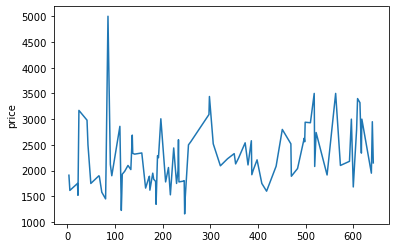

In [372]:
plt.figure()
sns.lineplot(data=ad_df.loc[ad_df['rooms']==3,'price'])
plt.show()